### Autoencoder with Convolutional Neural Network
This notebook contains the implementation of an autoencoder for augmentation of the histopathology dataset. The augmented data is used to train CNN networks to see if the accuracy and AUC are higher compared to the baseline CNN model trained on the normal dataset. First, the required libraries are imported and the size of the images in the PCAM dataset is defined.

In [1]:
# Load the functions and classes from main_util.py
from main_util import get_pcam_generators
from main_util import Model_architecture
from main_util import Model_transform

# Standard libraries
import matplotlib.pyplot as plt
%matplotlib inline
import os

# Modelcheckpoint and tensorboard callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.models import load_model

# ROC curve analysis
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

# the size of the images in the PCAM dataset
IMAGE_SIZE = 96

### Instantiating data generators

The PatchCAMELYON dataset is too big to fit in the working memory of most personal computers. This is why, we need to define some functions that will read the image data batch by batch, so only a single batch of images needs to be stored in memory at one time point. We can use the handy ImageDataGenerator function from the Keras API to do this. Note that the generators are defined within the function `get_pcam_generators` that returns them as output arguments. This function will later be called from the main code body. The function is located in `main_util.py`.


Before executing the code block below, do not forget to change the path where the PatchCAMELYON dataset is located (that is, the location of the folder that contains `train+val` that you previously downloaded and unpacked).

If everything is correct, the following output will be printed on screen after executing the code block:

`Found 144000 images belonging to 2 classes.`

`Found 16000 images belonging to 2 classes.`

In [2]:
path = "../"
train_gen, val_gen = get_pcam_generators(path, 
                                         train_batch_size=16, 
                                         val_batch_size=16,
                                         class_mode="binary")

Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.


### Training the baseline CNN model on regular data and evaluating the model

First, the model name and the necessary filepaths to save the model are defined in the code block below. 

In [ ]:
# Defining model name and paths
model_name = "cnn_baseline"
save_filepath = f"trained_models/{model_name}.tf"
model_filepath = f"trained_models/{model_name}.json"
weights_filepath = f"trained_models/{model_name}_weights.hdf5"

**The code block directly below can be used if the model is <font color='red'>already trained</font> and if the structure & weights are saved.** Training the model is not required in this case. The code block can be skipped if this is not the case. 

In [ ]:
# Load weights into the model (ONLY IF MODEL ALREADY EXISTS!!!)
model_cnn = load_model(save_filepath)

# Variables for ROC analysis
train_steps = train_gen.n//train_gen.batch_size
val_steps = val_gen.n//val_gen.batch_size

# Print statement to check if correct model is loaded
print(f"Successfully loaded the following model: {model_name}")

If the model is not trained yet, the following code blocks can be used to build the model and initiate the training phase. The model architectures are defined within the class `Model_architecture`. Organizing the code into classes instead of piling everything up in a single script makes the code more clear to read and understand, and helps reuse functionality that is already implemented. The class is located in `main_util.py`. In the code block below, an instance to the class is made and the structure of the baseline CNN model is loaded. 

In [ ]:
# Class instance is made
model_cnn = Model_architecture()
model_cnn.create_cnn(kernel_size=(3,3), pool_size=(4,4), first_filters=32, second_filters=64)
model_cnn.compile_cnn(learning_rate=0.001)

# Prints a summary of the model structure
model_cnn.summary();

In [ ]:
# Serialize model to JSON
model_json = model_cnn.to_json()
with open(model_filepath, 'w') as json_file:
    json_file.write(model_json) 

# Define the Tensorboard callback
checkpoint = ModelCheckpoint(weights_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
tensorboard = TensorBoard(os.path.join("logs", model_name))
callbacks_list = [checkpoint, tensorboard]

# Train the model
train_steps = train_gen.n//train_gen.batch_size//10
val_steps = val_gen.n//val_gen.batch_size//10

history = model_cnn.fit(train_gen, steps_per_epoch=train_steps,
                        validation_data=val_gen,
                        validation_steps=val_steps,
                        epochs=30,
                        callbacks=callbacks_list)

model_cnn.save(save_filepath)

Loss and accuracy curves are made for the training and validation set.

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(20,7))

# make plot for accuracy
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')


# make plot for loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

basedir = '.../project_map/main_project/metric_images/'
filename = basedir + model_name + '.png'
plt.savefig(filename)
#plt.show()

Now, ROC curve analysis is performed on the baseline CNN model.

In [ ]:
# Getting labels and predictions on validation set
val_true = val_gen.classes
val_probs = model_cnn.predict(val_gen, steps=val_steps*10)

# Calculating false positive rate (fpr), true positive rate (tpr) and AUC
fpr, tpr, thresholds = roc_curve(val_true, val_probs)
roc_auc = auc(fpr, tpr)

# Generate ROC curve
roc = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
fig, ax1 = plt.subplots(1, 1, figsize=(12, 8))

roc.plot(ax=ax1);
filename_auc = basedir + model_name + '_auc.png'
plt.savefig(filename_auc)

### Training and evaluating the autoencoder model

First, the model name and the filepath for the saved model are defined. Next, we need to construct new data generators. The training process of the autoencoder is unsupervised so the class mode of the data generators should be set to `input`. With these new generators, the autoencoder can be trained effectively. 

In [22]:
# Defining model name and paths
model_name = "autoencoder_Constantijn_2"
save_filepath = f"trained_models/{model_name}.tf"
model_filepath = f"trained_models/{model_name}.json"
weights_filepath = f"trained_models/{model_name}_weights.hdf5"

In [23]:
# Constructing the data generators for unsupervised learning for autoencoder training
train_gen_ae, val_gen_ae = get_pcam_generators(path, 
                                               train_batch_size=16, 
                                               val_batch_size=16, 
                                               class_mode="input") 

Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.


**The code block below can be used if there <font color='red'>already exists a trained version</font> of the autoencoder.** The weights are loaded into the model.

In [24]:
# Load weights into the model (ONLY IF MODEL ALREADY EXISTS!!!)
model_ae = load_model(save_filepath)

# Variables for ROC analysis
train_steps = train_gen_ae.n//train_gen_ae.batch_size
val_steps = val_gen_ae.n//val_gen_ae.batch_size

# Print statement to check if correct model is loaded
print(f"Successfully loaded the following model: {model_name}")

OSError: No file or directory found at trained_models/autoencoder_Constantijn_2.tf

If training is still required, the following code block can be used to construct the model and initiate the training phase. A new instance of the `Model_architecture` class is made for the autoencoder.

In [25]:
model_ae = Model_architecture()
model_ae.create_autoencoder(kernel_size=(3,3), pool_size=(2,2), first_filters=32, second_filters=16)
model_ae.compile_autoencoder(learning_rate=0.001)

model_ae.summary();

Model: "model_architecture_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 96, 96, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 48, 48, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 24, 24, 16)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 24, 24, 16)        2320      
                                                                 
 up_sampling2d_4 (UpSampling  (None, 48, 48, 1

In [26]:
# Serialize model to JSON
model_json = model_ae.to_json() 
with open(model_filepath, 'w') as json_file:
    json_file.write(model_json) 

# Define the Tensorboard callback
checkpoint = ModelCheckpoint(weights_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
tensorboard = TensorBoard(os.path.join("logs", model_name))
callbacks_list = [checkpoint, tensorboard]

# Train the model
train_steps = train_gen_ae.n//train_gen_ae.batch_size
val_steps = val_gen_ae.n//val_gen_ae.batch_size

history = model_ae.fit(train_gen_ae, steps_per_epoch=train_steps,
                        validation_data=val_gen_ae,
                        validation_steps=val_steps,
                        epochs=3,
                        callbacks=callbacks_list)

model_ae.save(save_filepath)

Epoch 1/3
9000/9000 [==============================] - ETA: 0s - loss: 0.0115
Epoch 1: val_loss improved from inf to 0.00928, saving model to trained_models\autoencoder_Constantijn_2_weights.hdf5
9000/9000 [==============================] - 1053s 117ms/step - loss: 0.0115 - val_loss: 0.0093
Epoch 2/3
9000/9000 [==============================] - ETA: 0s - loss: 0.0087
Epoch 2: val_loss improved from 0.00928 to 0.00844, saving model to trained_models\autoencoder_Constantijn_2_weights.hdf5
9000/9000 [==============================] - 918s 102ms/step - loss: 0.0087 - val_loss: 0.0084
Epoch 3/3
9000/9000 [==============================] - ETA: 0s - loss: 0.0080
Epoch 3: val_loss improved from 0.00844 to 0.00795, saving model to trained_models\autoencoder_Constantijn_2_weights.hdf5
9000/9000 [==============================] - 876s 97ms/step - loss: 0.0080 - val_loss: 0.0079


INFO:tensorflow:Assets written to: trained_models/autoencoder_Constantijn_2.tf\assets


INFO:tensorflow:Assets written to: trained_models/autoencoder_Constantijn_2.tf\assets


The output of the autoencoder model is visualized. This output  is used as augmented dataset in the upcoming steps.

1/1 [==============================] - 0s 71ms/step


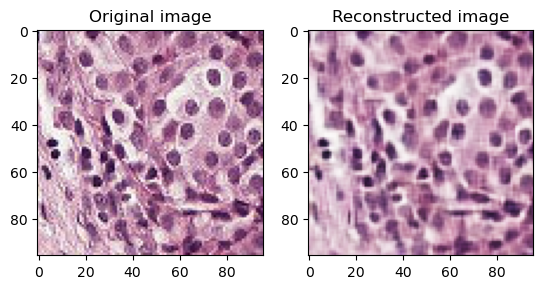

In [27]:
# Produce a prediction on the validation set
img_batch = train_gen_ae[0][1] # [batch][class][image_nr]
predict_test = model_ae.predict(img_batch) 
image_nr = 3

fig,ax = plt.subplots(1,2)
ax[0].imshow(img_batch[image_nr])
ax[0].set_title("Original image")
ax[1].imshow(predict_test[image_nr])
ax[1].set_title("Reconstructed image");

### Training CNN with augmented data using autoencoder

The generators for the augmented data are initialized with the autoencoder model as preprocessing function. This is done with the class `Model_transform`. This class is located in `main_util.py` and is responsible for augmenting the input of the data generators. 

In [28]:
# Constructing the data generators for the augmented dataset  
transformation = Model_transform(ae_model=model_ae, augmentation_factor=0.25)
train_gen_aug, val_gen_aug = get_pcam_generators(path, 
                                                 train_batch_size=16,
                                                 val_batch_size=16,
                                                 class_mode="binary", 
                                                 prep_function=transformation.model_transform)

Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.


The following code is to see if the generator works properly. It plots a few images of a batch to see the result.

In [ ]:
fig,ax = plt.subplots(1, 8)
for images, labels in train_gen_aug:
    for i in range(8):
        ax[i].imshow(images[i])
        ax[i].axis("off")
    break

The model name and filepaths for the saved model are defined.

In [29]:
# Defining model name and paths
model_name = "cnn_augmented_Constantijn_augfactor25"
save_filepath = f"trained_models/{model_name}.tf"
model_filepath = f"trained_models/{model_name}.json"
weights_filepath = f"trained_models/{model_name}_weights.hdf5"

**The code block below can be used if there <font color='red'>already exists a trained version</font> of the CNN with augmented data.** The weights are loaded into the model.

In [ ]:
# Load weights into the model (only if model structure & weight already exist!)
cnn_aug_model = load_model(save_filepath)

# Variables for ROC analysis
train_steps = train_gen_aug.n//train_gen_aug.batch_size
val_steps = val_gen_aug.n//val_gen_aug.batch_size

# Print statement to check if correct model is loaded
print(f"Successfully loaded the following model: {model_name}")

If training is still required, the following code block can be used to construct the model and initiate the training phase. A new instance of the `Model_architecture` class is made for the CNN trained with augmented data.

In [30]:
model_cnn_aug = Model_architecture()
model_cnn_aug.create_cnn(kernel_size=(3,3), pool_size=(4,4), first_filters=32, second_filters=64)
model_cnn_aug.compile_cnn(learning_rate=0.001)

model_cnn_aug.summary()

Model: "model_architecture_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 96, 96, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 conv2d_16 (Conv2D)          (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_17 (Conv2D)          (None, 1, 1, 64)          147520    
                                                                 
 conv2d_18 (Conv2D)          (None, 1, 1, 1)  

In [31]:
# Serialize model to JSON
model_json = model_cnn_aug.to_json() 
with open(model_filepath, 'w') as json_file:
    json_file.write(model_json) 

# Define the Tensorboard callback
checkpoint = ModelCheckpoint(weights_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
tensorboard = TensorBoard(os.path.join("logs", model_name))
callbacks_list = [checkpoint, tensorboard]

# Train the model
train_steps = train_gen_aug.n//train_gen_aug.batch_size//10
val_steps = val_gen_aug.n//val_gen_aug.batch_size//10

history = model_cnn_aug.fit(train_gen_aug, steps_per_epoch=train_steps,
                        validation_data=val_gen_aug,
                        validation_steps=val_steps,
                        epochs=30, 
                        callbacks=callbacks_list)

model_cnn_aug.save(save_filepath)
                            

Epoch 1/30
900/900 [==============================] - ETA: 0s - loss: 0.5622 - accuracy: 0.6999
Epoch 1: val_loss improved from inf to 0.41090, saving model to trained_models\cnn_augmented_Constantijn_augfactor25_weights.hdf5
900/900 [==============================] - 437s 485ms/step - loss: 0.5622 - accuracy: 0.6999 - val_loss: 0.4109 - val_accuracy: 0.8300
Epoch 2/30
900/900 [==============================] - ETA: 0s - loss: 0.4803 - accuracy: 0.7787
Epoch 2: val_loss did not improve from 0.41090
900/900 [==============================] - 425s 472ms/step - loss: 0.4803 - accuracy: 0.7787 - val_loss: 0.4234 - val_accuracy: 0.7962
Epoch 3/30
900/900 [==============================] - ETA: 0s - loss: 0.4684 - accuracy: 0.7822
Epoch 3: val_loss improved from 0.41090 to 0.39521, saving model to trained_models\cnn_augmented_Constantijn_augfactor25_weights.hdf5
900/900 [==============================] - 421s 468ms/step - loss: 0.4684 - accuracy: 0.7822 - val_loss: 0.3952 - val_accuracy: 0.8

INFO:tensorflow:Assets written to: trained_models/cnn_augmented_Constantijn_augfactor25.tf\assets


INFO:tensorflow:Assets written to: trained_models/cnn_augmented_Constantijn_augfactor25.tf\assets


Loss and accuracy curves are made for the training and validation set.

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(20,7))

# make plot for accuracy
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')


# make plot for loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

basedir = '.../project_map/main_project/metric_images/'
filename = basedir + model_name + '.png'
plt.savefig(filename)
#plt.show()

In [ ]:
# Getting labels and predictions on validation set
val_true = val_gen_aug.classes
val_probs = model_cnn_aug.predict(val_gen_aug, steps=val_steps*10)

# Calculating false positive rate (fpr), true positive rate (tpr) and AUC
fpr, tpr, thresholds = roc_curve(val_true, val_probs)
roc_auc = auc(fpr, tpr)

# Generate ROC curve
roc = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
roc.plot()